In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from IPython.display import clear_output

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import image_from_output, get_target, cuda2numpy, cuda2cpu, weights_init, load_classifier
from dataset import get_class_label, FaceDataset
from model import MinMax, SingleGenerator, SingleDiscriminator_solo_multi, Encoder, Encoder_classifier
from util_notebook import SRGAN_training, get_output_and_plot

# Introduction
---
In this notebook, we're going to explain the code to experiment with the Style-Restricted GAN with the encoder being pretrained with the classification tasks, focusing on the training procedure. The results will be examined in `05-test_Style-Restricted_GAN.ipynb`. The main purpose of this notebook is to prove that the pretrained encoder is able to control its diversification.


---

# CelebA Dataset
---
In this experiment, I'm gonna use the CelebA dataset, a face dataset that has plenty of annotations. We're therefore able to set various classes or conditions. I explained the details in `A_CelebA_dataset_usage.ipynb`.

---
### Preparation
---
First of all, navigate `root` to the root directory of the dataset and `label_root` to the directory of the label folder. `A_CelebA_dataset_usage.ipynb` also includes how the make the label folder.

---

In [3]:
###############################################
############ adjustable parameters ############

# root = "./../../dataset/celebA/img/"
# label_root = "./../../dataset/celebA/label_folder/"
root = "./../../research/sound_dataset/celebA/img_align_celeba_png/"
label_root = "./../../research/sound_dataset/celebA/label_folder/"

###############################################
###############################################

---
As I said, the CelebA dataset has plenty of annotations, so we need to define which annotation we're gonna use.
There are 3 ways to categorize the usage of the annotations.

- ***existed***: Get the images that belong to the selected annotations.
- ***delete***: Delete the images which belong to the selected annotations.
- ***class***: These annotations are used to compose the classes, \# of classes will be $2^{\#\_classes}$

In this experiment, I used some annotations owing to simplicity and 
set the classes by the use of annotations; "male", "smiling".

---

In [4]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

---
### Preprocessing
---
Firstly, The image in the dataset is center-cropped to be the shape (178, 178) and then resized to be the shape (128, 128). In the training process, the random horizontal flip is installed to augment the dataset. When it comes to the value of the image, it's normalized to a range of [-1, 1].


---

In [6]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

---
Let's have a look at some samples of the dataset.

---

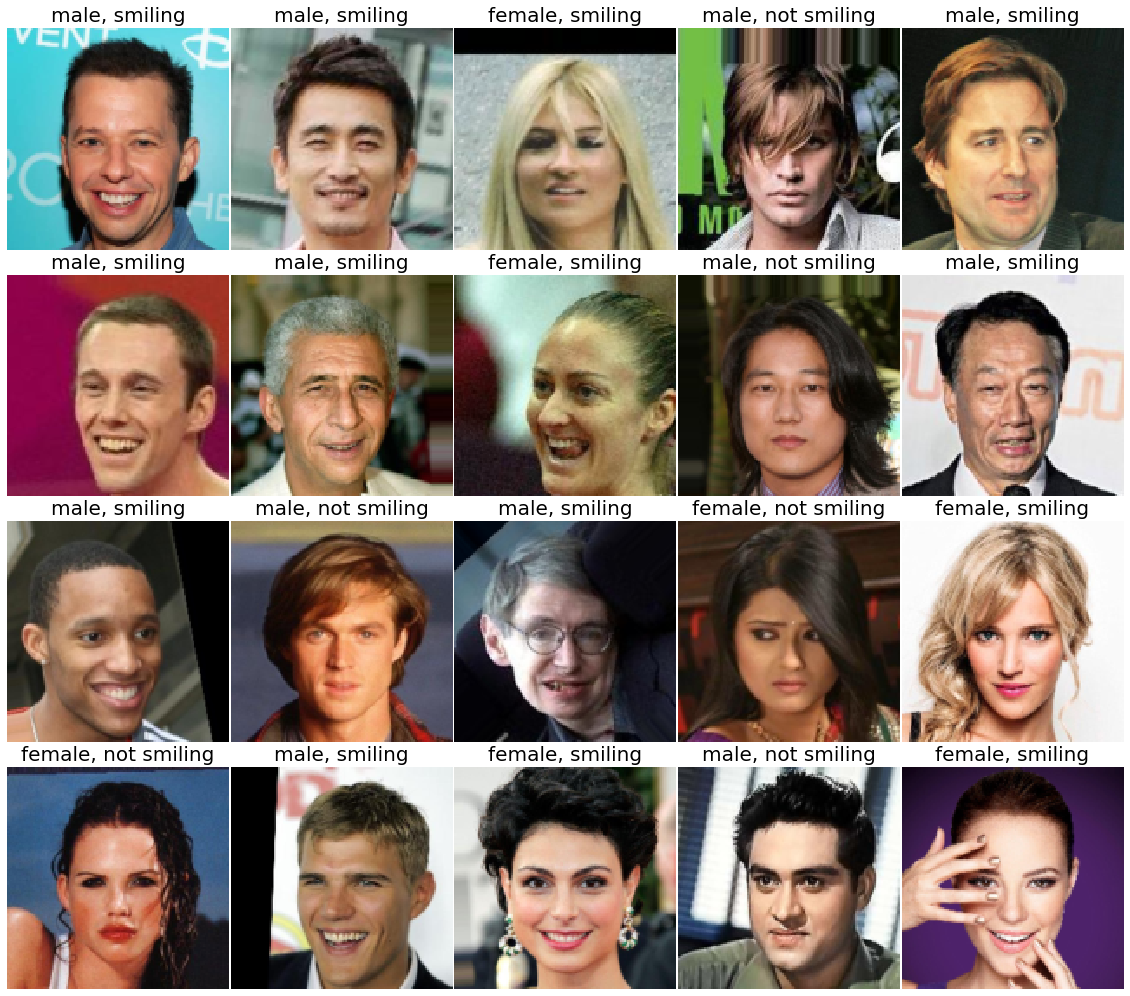

In [7]:
width = 5
length = 4
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=10000, val_num=0, test_num=100)
fig = plt.figure(figsize=(4*width, 4.5*length))
for i in range(width*length):
    ax = fig.add_subplot(length, width, i+1)
    index = np.random.randint(0,len(dataset))
    data = dataset[index]
    img = data[0]
    image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
    ax.imshow(image)
    ax.set_title(label_discription[data[1]], fontsize=20)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Training
---
Let's train the models.

---
### Preparation
---
At first, let's define some parameters for the architecture of the models, including a generator, a discriminator, and an encoder.

---

In [8]:
ndim = 8 # dimension of the latent code for style
nch_in = 3 # the number of channels for input images 

# Hyper-parameters for a generator
nch = 64 # the number of channels for the first convolutional layer
reduce = 2 # image's shape is reduced by a factor of this value
num_cls = 2 # the number of convolutional blocks for compression and expansion
res_num = 6 # the number of residual blocks

# Hyper-parameters for a generator
dis_reduce = 2 # image's shape is reduced by a factor of this value
dis_nch = 64 # the number of channels for the first convolutional layer
dis_num_cls = 4 # the number of convolutional blocks for compression
save_parameter = True # save parameters for the models or not
criterion = nn.MSELoss() # evaluation metrics for discriminator's output
criterion_class = nn.MSELoss() # evaluation metrics for discriminator's output (classification)
ref_label = np.eye(len(classes)) # class label: one-hot label is employed

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

---
Next, define more detailed information for the models and the lambda parameters for training.
In this experiment, we're just going to train the SRGAN with pretraining technique, so there is no adjustable parameter.

---

In [10]:
epoch_num = 31 # the number of epochs
lr_D = 0.0001 # initial learning rate for a Discriminator
lr_G = 0.0002 # initial learning rate for a Generator
lr_E = 0.001  # initial learning rate for an Encoder

model_type = "pretrained" # "nopretraining" or "pretrained": the encoder's status
restriction_type = "proposedKL" # "conventionalKL" or "proposedKL": employed losses for restriction of the encoder's distribution
if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu": the encoded features used for regression loss
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu": the encoded features used for regression loss

lbd = {}
lbd["class"] = 1 # loss for auxiliary classifier
lbd["cycle"] = 5 # cycle consistency loss
lbd["idt"] = 5 # identity loss
lbd["reg"] = 0.5 # conventional regression loss
lbd["idt_reg"] = 0.5 # regression loss for indentity images
    
if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1 # conventional KL divergence loss
    lbd["batch_KL"] = 0 # batch KL dvergence loss
    lbd["corr_enc"] = 0 # correlation loss
    lbd["hist"] = 0 # histogram imitation loss
elif restriction_type == "proposedKL":
    lbd["KL"] = 0 # conventional KL divergence loss
    lbd["batch_KL"] = 10 # batch KL dvergence loss
    lbd["corr_enc"] = 100 # correlation loss
    lbd["hist"] = 100 # histogram imitation loss
    
unrolled_k = 5 # k for UnrolledGAN

---
call training and sample dataset. The latter one is used to observe the result while training.

---

In [11]:
###############################################
############ adjustable parameters ############

batch_size = 128

###############################################
###############################################

dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=10000, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=10000, val_num=0, test_num=16)

---
Then, let's call the selected models. In our paper, we exploit multiple GPUs to reduce the training time. You can change the list of GPU you're gonna use.

- `devices`: the list of the GPU's id you will use

---

In [12]:
###############################################
############ adjustable parameters ############

devices = [0,1,2,3]

###############################################
###############################################

netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netG.apply(weights_init)
netG = nn.DataParallel(netG, devices)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
netD.apply(weights_init)
netD = nn.DataParallel(netD, devices)
netE = Encoder(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], device).to(device)
netE.apply(weights_init);

---
In Style-Restricted GAN, the main point is to restrict how the generator diversifies the result and we've proven pretraining with a classification task is good in restriction. Therefore, load the pretrained encoder when the `model_type` is set as "pretrained".

---

In [13]:
if model_type == "pretrained":
    model_path = f"../data/parameters/04/facial_recognizer_encoder_lr0.0001_epoch228.pth"
    netE = load_classifier(netE, model_path, device)
    classifier = Encoder_classifier(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
    classifier_layers = list(classifier.state_dict().keys())
    netE.freeze_melt(classifier_layers, "freeze")
    optE = optim.Adam(filter(lambda p: p.requires_grad, netE.parameters()), lr=0.001, betas=(0.5, 0.999))
    netE.freeze_melt(classifier_layers, "melt");
else:
    optE = None
netE = nn.DataParallel(netE, devices)

sg = SRGAN_training([netG, netD, netE], [None, None, optE], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, batch_size, encoded_feature, ndim)
sg.opt_sche_initialization()

_IncompatibleKeys(missing_keys=['fcmean.weight', 'fcmean.bias', 'fcvar.weight', 'fcvar.bias'], unexpected_keys=[])


---
Let's train your model. Since it takes time to process even just a single epoch, it shows the result 3 times in every epoch.

---

In [ ]:
run_train = True
if run_train:
    interval = int(len(dataset)/batch_size/3) + 2
    losses_D = []
    losses_G = []
    losses_E = []
    for epoch in range(epoch_num):
        start_time = time.time()
        loss_D = []
        loss_G = []
        loss_E = []
        for itr, data in enumerate(dataloader):
            netG.train()
            data_image = data[0]
            data_label = data[1]

            source_image = data_image.to(device)
            label = {}

            label["source"] = data_label.to(device)
            whole_target = get_target(data_label, classes, whole=False)
            label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")

            errG, errD, errE = sg.train(source_image, label)

            if type(errD)!=int:
                errD = errD.detach().to("cpu").numpy()
                loss_D.append(errD)
            if type(errG)!=int:
                errG = errG.detach().to("cpu").numpy()
                loss_G.append(errG)
            if type(errE)!=int:
                errE = errE.detach().to("cpu").numpy()
                loss_E.append(errE)

            if itr%interval==0:
                if not itr==0:
                    clear_output(wait=True)
                    print(f"epoch {epoch} :itr {itr}/{int(len(dataset)/batch_size)}: {(time.time()-start_time)/60} mins")
                    fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, device)

                    if not epoch==0:
                        length = 5
                        width = 4
                        losses = [losses_D, losses_G, losses_E]
                        ax = fig.add_subplot(length, width, 17)
                        models = ["Discriminator", "Generator", "Encoder"]
                        for k in range(len(losses)):
                            if models[k] == "Discriminator":
                                if type(losses[k]) == dict:
                                    for i in classes:
                                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                                elif type(losses[k]) == list:
                                    ax.plot(losses[k], label=f"Discriminator")
                            else:
                                ax.plot(losses[k], label=models[k])
                        ax.legend()
                    plt.show()

        if save_parameter:
            if epoch % 3 == 0:

                dir = "./instant_model_parameter/"
                gen_path = dir + f"gen_Style-RestrictedGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_class{lbd['class']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}.pth"
                dis_path = dir + f"dis_Style-RestrictedGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_class{lbd['class']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}.pth"
                enc_path = dir + f"enc_Style-RestrictedGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_class{lbd['class']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}.pth"
                
                torch.save(sg.G.module.state_dict(), gen_path)
                torch.save(sg.D.module.state_dict(), dis_path)
                torch.save(sg.E.module.state_dict(), enc_path)


        sg.scheD.step()
        losses_D.append(np.mean(loss_D))
        sg.scheG.step()
        losses_G.append(np.mean(loss_G))
        sg.scheE.step()
        losses_E.append(np.mean(loss_E))

        clear_output(wait=True)
        print(f"{epoch+1}: {(time.time()-start_time)/60} mins")
        fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, device)

        length = 5
        width = 4
        losses = [losses_D, losses_G, losses_E]
        ax = fig.add_subplot(length, width, 17)
        models = ["Discriminator", "Generator", "Encoder"]
        for k in range(len(losses)):
            if models[k] == "Discriminator":
                if type(losses[k]) == dict:
                    for i in classes:
                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                elif type(losses[k]) == list:
                    ax.plot(losses[k], label=f"Discriminator")
            else:
                ax.plot(losses[k], label=models[k])
        ax.legend()

        plt.show()